In [1]:
import pandas as pd
import numpy as np
import os
import sys
from scipy.stats.mstats import winsorize
import pandas as pd
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt

frame = pd.read_csv('data/original_mom.csv', index_col=0)
column_filter = [col for col in frame.columns if col >= '1990-01']
frame = frame[column_filter]

# frame
print(frame['1990-01'].max())

df_winsorized = frame.copy()
for col in frame.columns:
    # NaN이 아닌 값들만 선택
    non_nan_values = frame[col].dropna()
    # Winsorize 적용
    winsorized_values = winsorize(non_nan_values, limits=[0.01, 0.01])
    # 원래 컬럼에 NaN을 제외한 위치에 winsorize된 값을 할당
    df_winsorized[col].loc[non_nan_values.index] = winsorized_values

# 최종 winsorized 데이터의 '1990-01' 열에서의 최대값 확인
final_max_value = df_winsorized['1990-01'].max()
print(final_max_value)

12.0
0.3333333333333332


# Portfolio 성능 도출
* optimized_investment_strategy를 사용할 것

In [2]:
def optimized_investment_strategy(return_data_frame, 
                                  number_of_clusters, 
                                  threshold, batch=64, bins=32, hidden=128, 
                                  std=0.1, mask =0.1, bm=False, out_filter = 0.75):
    
    if bm:
        if bm == 'kmeans':
            cluster_dir = f'res/Clustering_Result/K-mean/'
        elif bm == 'agg':
            cluster_dir = f'res/Clustering_Result/Agglomerative/'
        elif bm == 'dbscan':
            cluster_dir = f'res/Clustering_Result/DBSCAN/'
    else:
        cluster_dir = f'res/batch_{batch}_n_bins_{bins}_hidden_{hidden}_std_{std}_mask_{mask}/predictions/{number_of_clusters}_characteristics_us'
        prob_dir = f'res/batch_{batch}_n_bins_{bins}_hidden_{hidden}_std_{std}_mask_{mask}/prob/{number_of_clusters}_characteristics_us'
        
        assert os.path.exists(prob_dir), 'prob_dir does not exist'
        prob_results = glob(prob_dir + '/*')
        prob_results.sort()
        
    cluster_results = glob(cluster_dir + '/*')
    cluster_results.sort()

    print(cluster_results)

    all_months = return_data_frame.columns

    cumulative_return = 0
    cumulative_returns_list = []
    log_returns_list = []
    LS_table = []

    progress_bar = tqdm(all_months, desc="Processing assets")
    for idx, current_month in enumerate(progress_bar):

        assert str(cluster_results[idx].split('/')[-1].split('.')[0]) == str(current_month), '월이 일치하지 않음'

        next_month = all_months[idx+1] if idx+1 < len(all_months) else None
        if next_month is None:
            continue
        
        cluster_data = pd.read_csv(cluster_results[idx], index_col=0)

        if not bm:
            prob_data = pd.read_csv(prob_results[idx], index_col='firms')
            # 전체 probability 분포 상에서 상위 25~50%에 해당하는 firm만 선택
            prob_data['max_prob'] = prob_data.max(axis=1)
            median_max_prob = prob_data['max_prob'].quantile(out_filter) # ! 0.65 , 0.75 확연히 뛰어남
            combined_data = cluster_data.merge(prob_data, left_on='firms', right_index=True)
            combined_data['clusters'] = np.where(combined_data['max_prob'] > median_max_prob, combined_data['clusters'], 0)
            cluster_data = combined_data[['clusters', 'mom1']]
            
        cluster_data = cluster_data[cluster_data['clusters'] != 0]
        cluster_data.sort_values(by='mom1', ascending=False, inplace=True)

        # 스프레드 계산
        cluster_data['spread'] = cluster_data.groupby('clusters')['mom1'].transform(lambda x: x.sort_values(ascending=False).values - x.sort_values(ascending=True).values)
        spreadStd = cluster_data['spread'].std()

        cluster_data['Long_or_Short'] = (-cluster_data['spread'] / cluster_data['spread'].abs())
        cluster_data['inPortfolio'] = cluster_data['spread'].abs() > spreadStd * threshold

        long_firms = cluster_data[(cluster_data['Long_or_Short'] == 1) & cluster_data['inPortfolio']]
        short_firms = cluster_data[(cluster_data['Long_or_Short'] == -1) & cluster_data['inPortfolio']]

        # 포트폴리오 가치 계산
        equityReturnsCopy = copy.deepcopy(return_data_frame)
        EarningNextMonth = equityReturnsCopy[next_month]
        EarningNextMonth[short_firms.index] *= -1
        EarningNextMonth.clip(upper=None, lower=-0.3, inplace=True)  # stop loss less than -0.3
        EarningNextMonth.fillna(-0.5, inplace=True)  # fillna with -0.5 for delisted firms

        earning = (EarningNextMonth[long_firms.index].sum() + EarningNextMonth[short_firms.index].sum()) / (len(long_firms.index) + len(short_firms.index))
        progress_bar.set_postfix({'earning': earning, 'total number': len(long_firms.index) + len(short_firms.index)})

        log_return = np.log(1 + earning)
        log_returns_list.append(log_return)
        cumulative_return = np.exp(np.log(1 + cumulative_return) + log_return) - 1
        cumulative_returns_list.append(cumulative_return)
        
    print("포트폴리오 수익률: ", cumulative_return)       
    return cumulative_return, cumulative_returns_list, log_returns_list


In [3]:
cumulative_return_kmeans_100, cumulative_returns_list_kmeans_100, log_returns_list_kmeans_100 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=100, threshold=1, bm='kmeans')
# cumulative_return_agg, cumulative_returns_list_agg, log_returns_list_agg = optimized_investment_strategy(
#     df_winsorized, number_of_clusters=100, threshold=1, bm='agg')
# cumulative_return_dbscan, cumulative_returns_list_dbscan, log_returns_list_dbscan = optimized_investment_strategy(
#     df_winsorized, number_of_clusters=100, threshold=1, bm='dbscan')

['res/Clustering_Result/K-mean/1990-01.csv', 'res/Clustering_Result/K-mean/1990-02.csv', 'res/Clustering_Result/K-mean/1990-03.csv', 'res/Clustering_Result/K-mean/1990-04.csv', 'res/Clustering_Result/K-mean/1990-05.csv', 'res/Clustering_Result/K-mean/1990-06.csv', 'res/Clustering_Result/K-mean/1990-07.csv', 'res/Clustering_Result/K-mean/1990-08.csv', 'res/Clustering_Result/K-mean/1990-09.csv', 'res/Clustering_Result/K-mean/1990-10.csv', 'res/Clustering_Result/K-mean/1990-11.csv', 'res/Clustering_Result/K-mean/1990-12.csv', 'res/Clustering_Result/K-mean/1991-01.csv', 'res/Clustering_Result/K-mean/1991-02.csv', 'res/Clustering_Result/K-mean/1991-03.csv', 'res/Clustering_Result/K-mean/1991-04.csv', 'res/Clustering_Result/K-mean/1991-05.csv', 'res/Clustering_Result/K-mean/1991-06.csv', 'res/Clustering_Result/K-mean/1991-07.csv', 'res/Clustering_Result/K-mean/1991-08.csv', 'res/Clustering_Result/K-mean/1991-09.csv', 'res/Clustering_Result/K-mean/1991-10.csv', 'res/Clustering_Result/K-mean/1

Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  10636.812640469887


In [86]:

out_filter = 0.5 # ! Outlier filter : 0 ~ 0.99 사이 어딘가? 0.5(2.5) 0.75(2.55)
thres = 1
batch = 128
hidden = 128
bins = 64
std = 0.1
mask = 0.1

# cumulative_return_1, cumulative_returns_list_1, log_returns_list_1 = optimized_investment_strategy(
#     df_winsorized, number_of_clusters=40, threshold=thre, batch=batch, bins=bins, hidden=hidden, mask=mask, std= std,out_filter=out_filter)
# cumulative_return_2, cumulative_returns_list_2, log_returns_list_2 = optimized_investment_strategy(
#     df_winsorized, number_of_clusters=50, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std,out_filter=out_filter)
cumulative_return_3, cumulative_returns_list_3, log_returns_list_3 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=60, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)
cumulative_return_4, cumulative_returns_list_4, log_returns_list_4 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=70, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)
cumulative_return_5, cumulative_returns_list_5, log_returns_list_5 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=80, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)
cumulative_return_6, cumulative_returns_list_6, log_returns_list_6 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=90, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)
# cumulative_return_7, cumulative_returns_list_7, log_returns_list_7 = optimized_investment_strategy(
#     df_winsorized, number_of_clusters=100, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)

['res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/60_characteristics_us/1990-01.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/60_characteristics_us/1990-02.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/60_characteristics_us/1990-03.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/60_characteristics_us/1990-04.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/60_characteristics_us/1990-05.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/60_characteristics_us/1990-06.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/60_characteristics_us/1990-07.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/60_characteristics_us/1990-08.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/60_characteristics_us/1990-09.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/60_characteristics_us/199

Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  33560.98945894266
['res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/70_characteristics_us/1990-01.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/70_characteristics_us/1990-02.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/70_characteristics_us/1990-03.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/70_characteristics_us/1990-04.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/70_characteristics_us/1990-05.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/70_characteristics_us/1990-06.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/70_characteristics_us/1990-07.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/70_characteristics_us/1990-08.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/70_characteristics_us/1990-09.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predict

Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  109941.76976135049
['res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/80_characteristics_us/1990-01.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/80_characteristics_us/1990-02.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/80_characteristics_us/1990-03.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/80_characteristics_us/1990-04.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/80_characteristics_us/1990-05.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/80_characteristics_us/1990-06.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/80_characteristics_us/1990-07.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/80_characteristics_us/1990-08.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/80_characteristics_us/1990-09.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predic

Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  116842.8230663263
['res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/90_characteristics_us/1990-01.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/90_characteristics_us/1990-02.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/90_characteristics_us/1990-03.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/90_characteristics_us/1990-04.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/90_characteristics_us/1990-05.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/90_characteristics_us/1990-06.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/90_characteristics_us/1990-07.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/90_characteristics_us/1990-08.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predictions/90_characteristics_us/1990-09.csv', 'res/batch_128_n_bins_64_hidden_128_std_0.1_mask_0.1/predict

Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  57152.437119023016


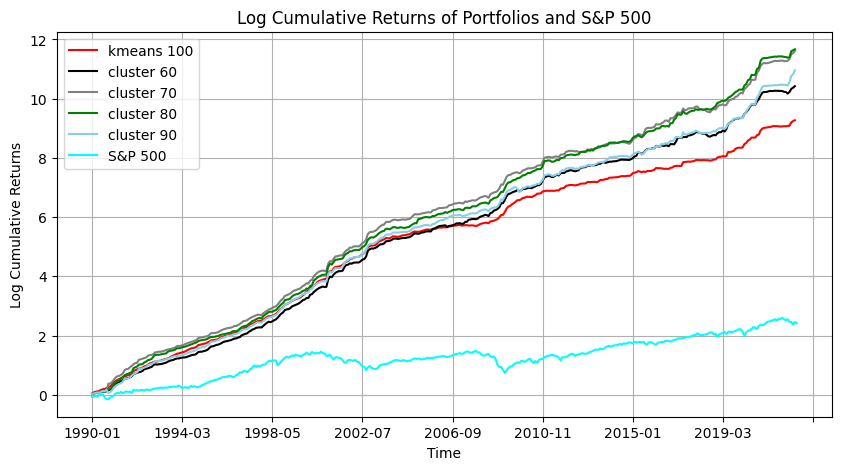

In [88]:
sp = pd.read_csv('data/sp500.csv', index_col=0)

plt.figure(figsize=(10, 5))

# plt.plot(np.cumsum(log_returns_list_kmeans_10), label='kmeans 10', color='blue', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_kmeans_20)+1), label='kmeans 20', color='orange', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_kmeans_30)+1), label='kmeans 30', color='green', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_kmeans_50)+1), label='kmeans 50', color='black', linestyle='solid')
plt.plot(np.log(np.array(cumulative_returns_list_kmeans_100)+1), label='kmeans 100', color='red', linestyle='solid')

# plt.plot(np.cumsum(log_returns_list_1), label='cluster 10', color='purple', linestyle='solid')
# plt.plot(np.cumsum(log_returns_list_2), label='cluster 50', color='blue', linestyle='solid')
plt.plot(np.cumsum(log_returns_list_3), label='cluster 60', color='black', linestyle='solid')
plt.plot(np.cumsum(log_returns_list_4), label='cluster 70', color='grey', linestyle='solid')
plt.plot(np.cumsum(log_returns_list_5), label='cluster 80', color='green', linestyle='solid')
plt.plot(np.cumsum(log_returns_list_6), label='cluster 90', color='skyblue', linestyle='solid')
# plt.plot(np.cumsum(log_returns_list_7), label='cluster 100', color='orange', linestyle='solid')

np.log((sp['Monthly Returns']+1).cumprod()).plot(label='S&P 500', color='cyan', linestyle='solid')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Log Cumulative Returns')
plt.title('Log Cumulative Returns of Portfolios and S&P 500')
plt.grid(True)
plt.show()

In [91]:
def calculate_metrics(log_returns_list, target_return=0.0):
    # Convert log returns to simple returns for some metrics
    simple_returns = np.exp(log_returns_list) - 1

    # Sharpe Ratio (using simple returns)
    sharpe_ratio = np.sqrt(12) * np.mean(simple_returns) / np.std(simple_returns)
    
    # Max Drawdown Percent
    def calculate_mdd(log_returns):
        # 누적 수익률 계산
        cumulative_returns = np.cumsum(log_returns)
        # 누적 최대 수익률 계산
        cumulative_max = np.maximum.accumulate(cumulative_returns)
        # Drawdown 계산
        drawdown = cumulative_max - cumulative_returns
        # MDD 계산
        mdd = np.max(drawdown)
        
        return mdd
    
    max_drawdown = calculate_mdd(log_returns_list)
    
    # Annual Return (based on log returns)
    annual_return = np.exp(np.mean(log_returns_list) * 12) - 1

    # Standard Deviation (annualized, based on simple returns)
    standard_deviation = np.std(simple_returns) * np.sqrt(12)
    
    def calculate_sortino_ratio(returns, target_return=0):
        # 예상 수익률 계산
        expected_return = np.mean(returns)
        
        # downside deviation 계산
        downside_returns = [ret for ret in returns if ret < target_return]
        downside_deviation = np.std(downside_returns, ddof=1)
        
        # Sortino 비율 계산
        sortino_ratio = (expected_return - target_return) / downside_deviation
        
        return sortino_ratio
    
    sortino_ratio = calculate_sortino_ratio(simple_returns)

    return sharpe_ratio, annual_return, standard_deviation, max_drawdown, sortino_ratio


sharpe_ratio_kmeans, annual_return_kmeans, standard_deviation_kmeans, mdd_kmeans, sortiono_kmeans = calculate_metrics(log_returns_list_kmeans_100)
# sharpe_ratio1, annual_return1, standard_deviation1 = calculate_metrics(log_returns_list_1)
#sharpe_ratio2, annual_return2, standard_deviation2 = calculate_metrics(log_returns_list_2)
sharpe_ratio3, annual_return3, standard_deviation3, mdd3 , sortino3 = calculate_metrics(log_returns_list_3)
sharpe_ratio4, annual_return4, standard_deviation4, mdd4 , sortino4 = calculate_metrics(log_returns_list_4)
sharpe_ratio5, annual_return5, standard_deviation5, mdd5 , sortino5 = calculate_metrics(log_returns_list_5)
sharpe_ratio6, annual_return6, standard_deviation6, mdd6 , sortino6 = calculate_metrics(log_returns_list_6)
# sharpe_ratio7, annual_return7, standard_deviation7 = calculate_metrics(log_returns_list_7)

df = pd.DataFrame({'sharpe_ratio': [sharpe_ratio_kmeans,  sharpe_ratio3, sharpe_ratio4, sharpe_ratio5, sharpe_ratio6],
                     'annual_return': [annual_return_kmeans, annual_return3, annual_return4, annual_return5, annual_return6],
                     'standard_deviation': [standard_deviation_kmeans, standard_deviation3, standard_deviation4, standard_deviation5, standard_deviation6],
                     'sortino_ratio': [sortiono_kmeans, sortino3, sortino4, sortino5, sortino6],
                    'max_drawdown': [mdd_kmeans, mdd3, mdd4, mdd5, mdd6]},
                    index=['kmeans', 'cluster3', 'cluster4', 'cluster5', 'cluster6', ])
# best sharpe ratio
print(df.idxmax())
df.T

sharpe_ratio            kmeans
annual_return         cluster5
standard_deviation    cluster4
sortino_ratio           kmeans
max_drawdown          cluster4
dtype: object


,kmeans,cluster3,cluster4,cluster5,cluster6
sharpe_ratio,2.886977,2.540122,2.402087,2.497008,2.323792
annual_return,0.329188,0.376895,0.427960,0.430631,0.399575
standard_deviation,0.101423,0.130755,0.155145,0.149699,0.151307
sortino_ratio,4.827277,1.922988,1.875333,2.645713,1.383574
max_drawdown,0.038801,0.152327,0.192140,0.089020,0.163249


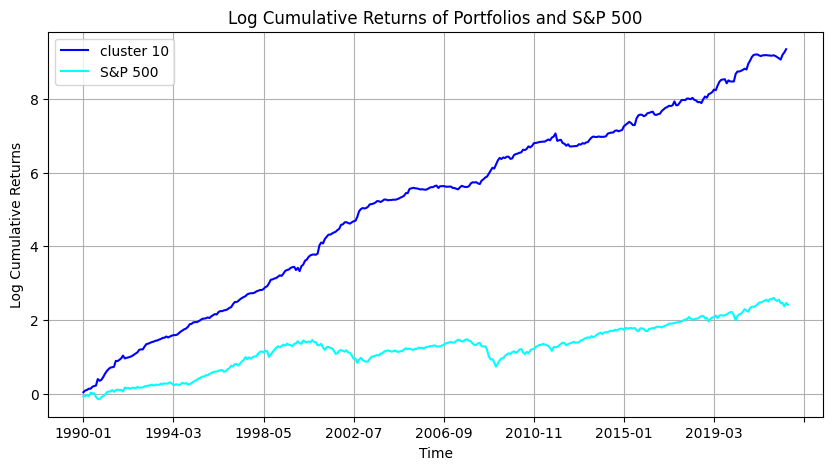

In [35]:
# 데이터 로드
sp = pd.read_csv('sp500.csv', index_col=0)

# 그래프 설정
plt.figure(figsize=(10, 5))

# 라인 플롯
plt.plot(np.log(np.array(cumulative_returns_list_10)+1), label='cluster 10', color='blue', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_2)+1), label='cluster 20', color='red', linestyle='dashed')
# plt.plot(np.log(np.array(cumulative_returns_list_3)+1), label='cluster 30', color='green', linestyle='dotted')
# plt.plot(np.log(np.array(cumulative_returns_list_4)+1), label='cluster 40', color='purple', linestyle='dashdot')
# plt.plot(np.log(np.array(cumulative_returns_list_5)+1), label='cluster 50', color='orange', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_6)+1), label='cluster 60', color='black', linestyle='dashed')
np.log((sp['Monthly Returns']+1).cumprod()).plot(label='S&P 500', color='cyan', linestyle='solid')

# 레전드
plt.legend()

# 축 레이블
plt.xlabel('Time')
plt.ylabel('Log Cumulative Returns')

# 타이틀
plt.title('Log Cumulative Returns of Portfolios and S&P 500')

# 그리드
plt.grid(True)

# 그래프 표시
plt.show()